In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from source.split_bregman_gcs import SplitBregmanGCS, NormalizationMode
from source.utils import normalization_automatic
from source.image_force import Force1, Force2, Force3


# Evaluation Energy Functions

In [2]:
initial_level_set = cv.imread('test_images/simplify_cells_distance_multiply_10.tif', cv.CV_8U)
initial_level_set = normalization_automatic(initial_level_set)
image = cv.imread('test_images/simplify_cells.tif', cv.CV_16U) 
image = normalization_automatic(image)

In [3]:
k0 = 1
k1 = 1
sigma = 1
force1 = Force1(image, k0=k0, k1=k1)
r1 = force1.compute_force(initial_level_set>0)
force2 = Force2(image)
r2 = force2.compute_force(initial_level_set>0)
force3 = Force3(image, k0=k0, k1=k1, sigma=sigma)
r3 = force3.compute_force(initial_level_set>0)


c:\Users\tania\OneDrive\Documentos\medical_image\medical-image-project\source\image_force.py:44: RuntimeWarning: divide by zero encountered in log
  r = np.log(self.proba_in()) - np.log(self.proba_out())


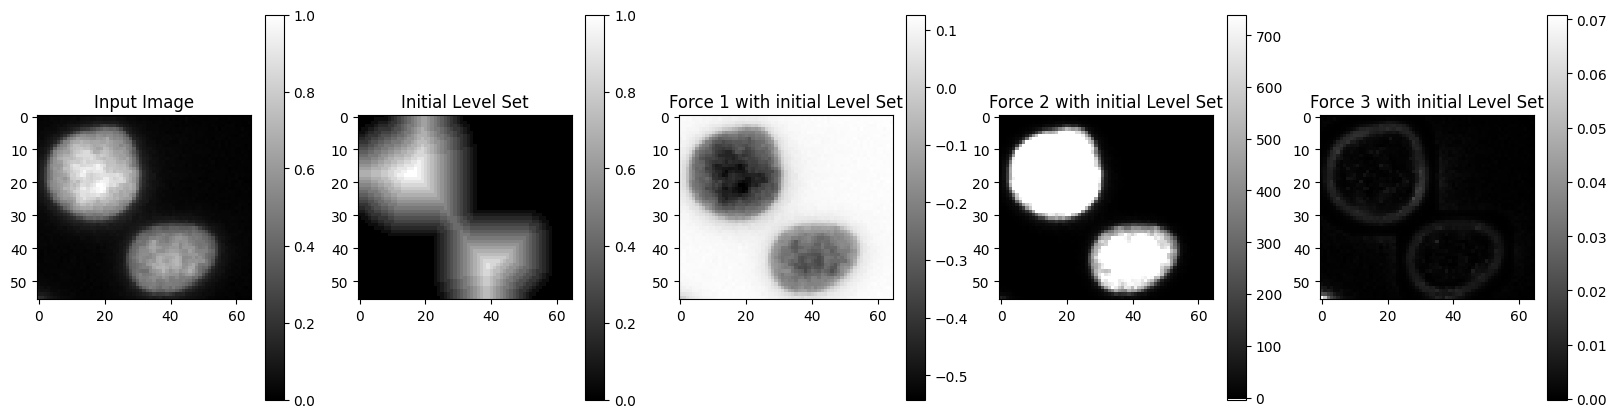

In [4]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
ax[0].set_title('Input Image')
pos = ax[0].imshow(image, 'gray')
fig.colorbar(pos, ax=ax[0])

ax[1].set_title('Initial Level Set')
pos = ax[1].imshow(initial_level_set, 'gray')
fig.colorbar(pos, ax=ax[1])

ax[2].set_title('Force 1 with initial Level Set')
pos = ax[2].imshow(r1, 'gray')
fig.colorbar(pos, ax=ax[2])


ax[3].set_title('Force 2 with initial Level Set')
pos = ax[3].imshow(r2, 'gray')
fig.colorbar(pos, ax=ax[3])


ax[4].set_title('Force 3 with initial Level Set')
pos = ax[4].imshow(r3, 'gray')
fig.colorbar(pos, ax=ax[4])
plt.show()



## Force 1
Definition:
\begin{equation}
    r_1 = \kappa_1(I(x) - \mu_1)^2 - \kappa_0(I(x) - \mu_0)^2
\end{equation} 

where $\mu_1$ is the mean value of the region inside the contour and $\mu_0$ the mean value of the region outside.

## Force 2

Definition:

\begin{equation}
    r_2 = log( P(I(x)|\Omega_1)- log( P(I(x)|\Omega_0)
\end{equation}

where $P(I(x)|\Omega_i) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(I(x)-\mu_i)^2}{2\sigma_i^2}}$


## Force 3

The formulation of this force is the following:
\begin{equation}
r_3 = \kappa_1\int K_{\sigma}(y-x) |I(x) - f_1(y)|^2 dy - \kappa_0\int K_{\sigma}(y-x) |I(x) - f_0(y)|^2 dy
\end{equation}

where $K_{\sigma}(u) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{|u|^2}{2\sigma^2}}$ is a Gaussian Kernel and the functions $f_0$ and $f_1$ are the inside and outside approximation of the the image centered at each point. Defined by:
\begin{align}
f_0 = \frac{K_\sigma(x) * [(1 - H(\phi(x))) I(x)]}{K_\sigma(x) * [1 - H(\phi(x))]}\\ 
f_1 = \frac{K_\sigma(x) * [H(\phi(x)) I(x)]}{K_\sigma(x) * H(\phi(x))}
\end{align}

For simplicity, in the code we removed the use of Heaviside function by using masks.

Let's consider $M_{in}$ the image mask which is one when we are inside the region and $M_{out}$ the image mask which is one when we are outside the region. Given this difiniation we can define: $I_{in}$ and $I{out}$ their respective masked images.

We can rewrite the equations $f_{in}$($f_1$) and $f_{out}$($f_0$) as:
\begin{align*}
f_{in} &= \frac{K_\sigma(x) *I_{in}(x)}{K_\sigma(x) * M_{in}(x)}\\ 
f_{out} &= \frac{K_\sigma(x) *I_{out}(x)}{K_\sigma(x) * M_{out}(x)}
\end{align*}

The convolution on the denominator will be always its corresponding mask, because $M_{in}$ and $M_{out}$ are arrays with only 0 and 1. Then, we can rewrite:
\begin{align}
f_{in} &= K_\sigma(x) *I_{in}(x)\\ 
f_{out} &= K_\sigma(x) *I_{out}(x)
\end{align}


Then the force could be define as:
\begin{align*}
r_3(x) &= \kappa_1 \sum_{y \in interior } K_{\sigma}(y-x) |I(x) - f_{in}(y)|^2 - \kappa_0 \sum_{y \in outside} K_{\sigma}(y-x) |I(x) - f_{out}(y)|^2\\
r_3(x) &= \kappa_1 \sum_{y \in interior } K_{\sigma}(y-x) [I^2(x) -2I(x)f_{in}(y) +f_{in}^2(y)] - \kappa_0 \sum_{y \in outside} K_{\sigma}(y-x) [I^2(x) - 2 I(x) f_{out}(y) + f_{out}^2(y)]\\
r_3(x) &= (\kappa_1 - \kappa_0) \sum_{y \in image } K_{\sigma}(y-x) I^2(x) - 2\kappa_1 I(x) \sum_{y \in inside}K_{\sigma}(y-x)f_{in}(y) + 2\kappa_0 I(x) \sum_{y \in outside} K_{\sigma}(y-x)f_{out}(y) + \kappa_1 \sum_{y \in inside} K_{\sigma}(y-x)f_{in}^2(y) - \kappa_0 \sum_{y \in outside} K_{\sigma}(y-x)f_{out}^2(y) \\
r_3(x) &= (\kappa_1 - \kappa_0)  (K_{\sigma} * I^2) (x) -  2\kappa_1 I(x) [(K_{\sigma} * f_{in})(x)] + 2\kappa_0 I(x) [(K_{\sigma} * f_{out})(x)] + \kappa_1 (K_{\sigma} * f_{in}^2)(x) - \kappa_0 (K_{\sigma} * f_{out}^2)(x) 
\end{align*}

In the usual definition of Gaussian Kernel, we have two parameters `kernel_size` and `sigma`. However, in the articles the authors consider only sigma and they afirm that sigma control the size of the region in which the image intensities are approximated. Taking this into consideration, in our implementation, we decide that  `kernel_size = (2*sigma+1, 2*sigma+1)`, to obtain a valid kernel size for every sigma (it has to be an integer).



### Local Function Approximation

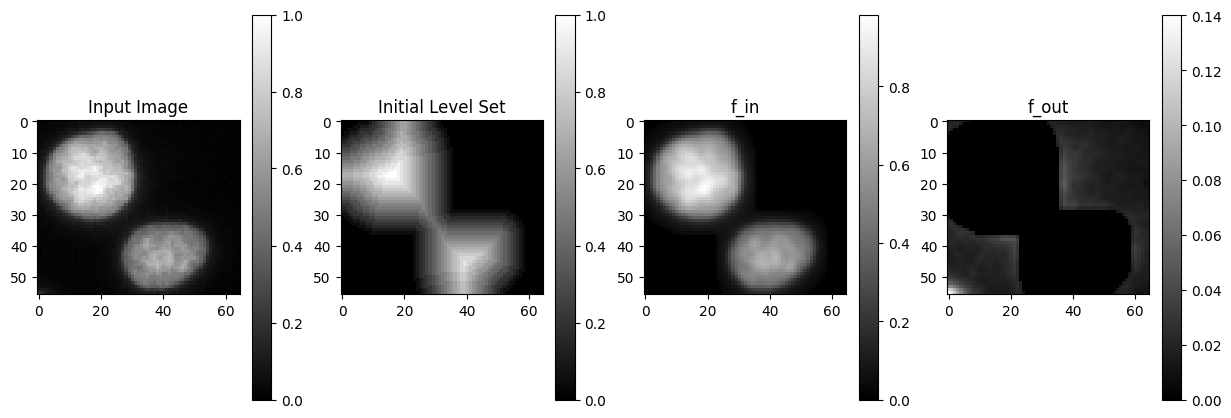

In [5]:
f_in = force3.f_in()
f_out = force3.f_out()
fig, ax = plt.subplots(1,4, figsize=(15,5))

ax[0].set_title('Input Image')
pos = ax[0].imshow(image, 'gray')
fig.colorbar(pos, ax=ax[0])

ax[1].set_title('Initial Level Set')
pos = ax[1].imshow(initial_level_set, 'gray')
fig.colorbar(pos, ax=ax[1])

ax[2].set_title('f_in')
pos = ax[2].imshow(f_in, 'gray')
fig.colorbar(pos, ax=ax[2])

ax[3].set_title('f_out')
pos = ax[3].imshow(f_out, 'gray')
fig.colorbar(pos, ax=ax[3])

**Observation**

Visually the aproximation for the interior seems to be coherent. However, the approximation for the outside of the level set has a little artifact at the left corner that is probably an border artifact.

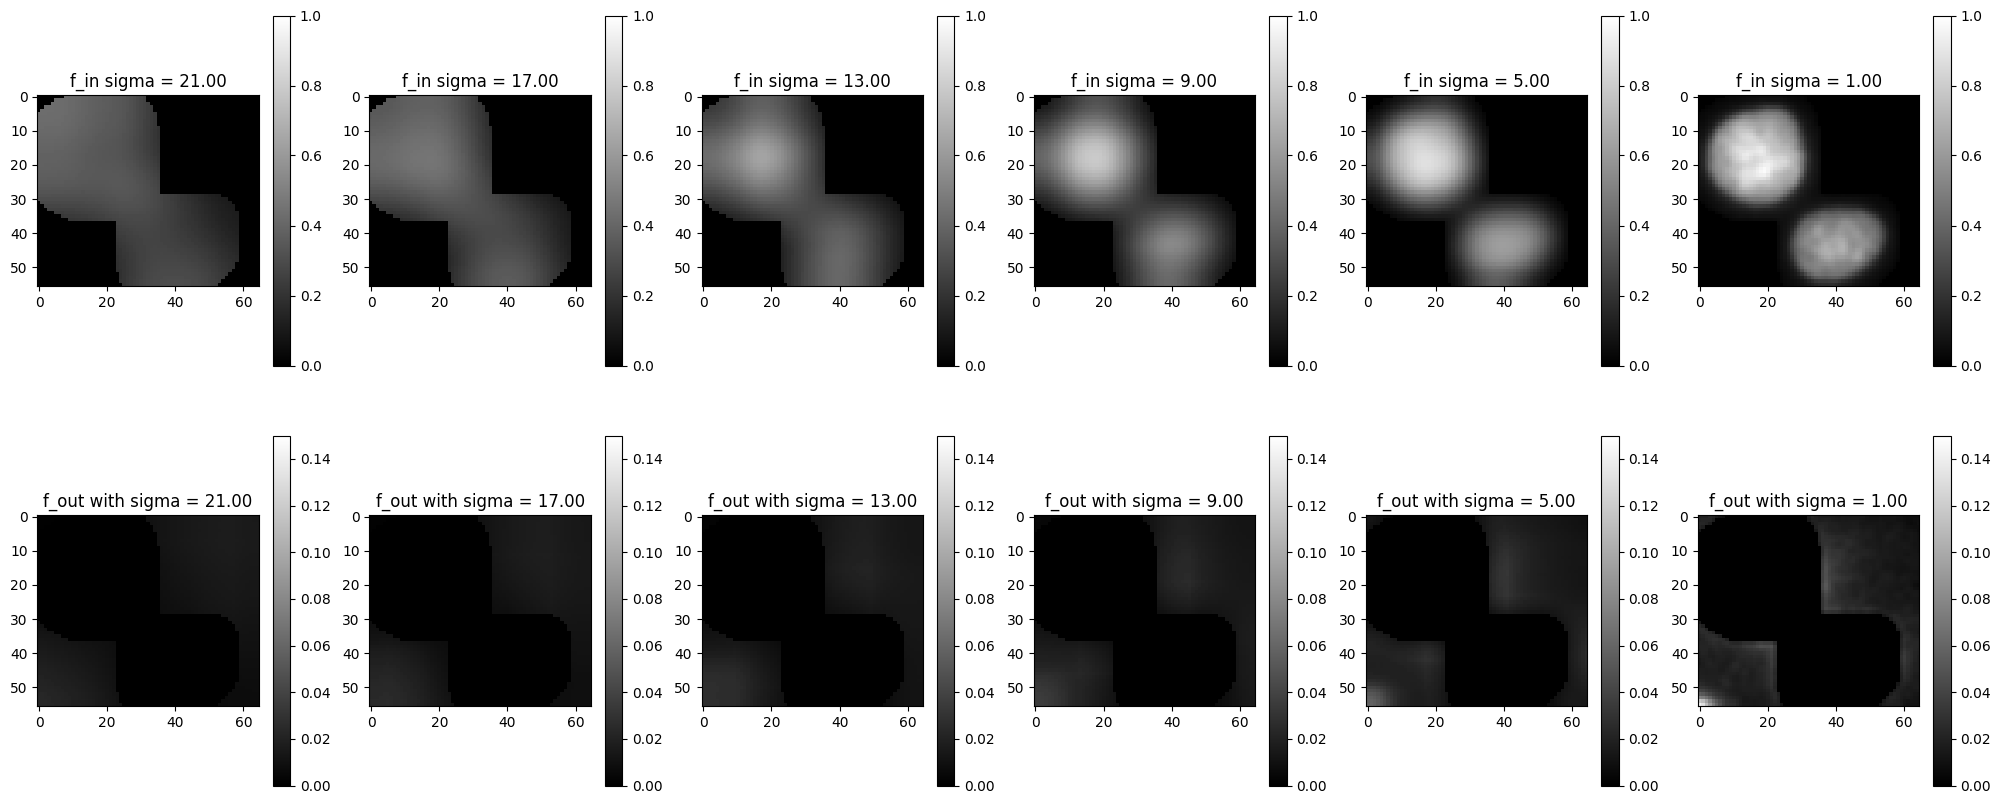

In [6]:
sigma_list = np.arange(1, 25, 4)
vmin_r3, vmax_r3 = 0, 1
vmin_out, vmax_out = 0, .15
N = len(sigma_list)
fig, ax = plt.subplots(2,N, figsize=(5*(N-1),10))
for i, sigma in enumerate(sigma_list[::-1]):
    force3 = Force3(image, k0=k0, k1=k1, sigma=sigma)
    _ = force3.compute_force(initial_level_set>0)
    f_in = force3.f_in()
    f_out = force3.f_out()

    ax[0, i].set_title(f'f_in sigma = {sigma:.2f}')
    pos = ax[0, i].imshow(f_in, 'gray', vmin=vmin_r3, vmax=vmax_r3)
    fig.colorbar(pos, ax=ax[0, i])

    ax[1, i].set_title(f'f_out with sigma = {sigma:.2f}')
    pos = ax[1, i].imshow(f_out, 'gray', vmin=vmin_out, vmax=vmax_out)
    fig.colorbar(pos, ax=ax[1, i])

    if np.min(f_in) < vmin_r3 or np.max(f_in) > vmax_r3:
        print(f'Visualization error!! The selected vmin and vmax for the region inside are not valid') 
    if np.min(f_out) < vmin_out or np.max(f_out) > vmax_r3:
        print(f'Visualization error!! The selected vmin and vmax for the region outside are not valid')
    




**Observation**

As we expected, when we lower the parameter $\sigma$ our functions $f_{in}$ and $f_{out}$ are a more local approximation. Then when we lower $\sigma$ parameter $f_{in} + f_{out} \approx I$



### Evolution of the force

If we consider $k_1 = k_2$ as they do in the paper. Using convolution properties we can rewrite the force like:
\begin{align}
r_3(x) &= -  2\kappa I(x) [(K_{\sigma} * f_{in})(x)] + 2\kappa I(x) [(K_{\sigma} * f_{out})(x)] + \kappa (K_{\sigma} * f_{in}^2)(x) - \kappa (K_{\sigma} * f_{out}^2)(x) \\
r_3(x) &= -  2\kappa I(x) [(K_{\sigma} * (f_{in}-f_{out})(x)] + \kappa (K_{\sigma} * (f_{in}^2 + f_{out}^2))(x)
\end{align}


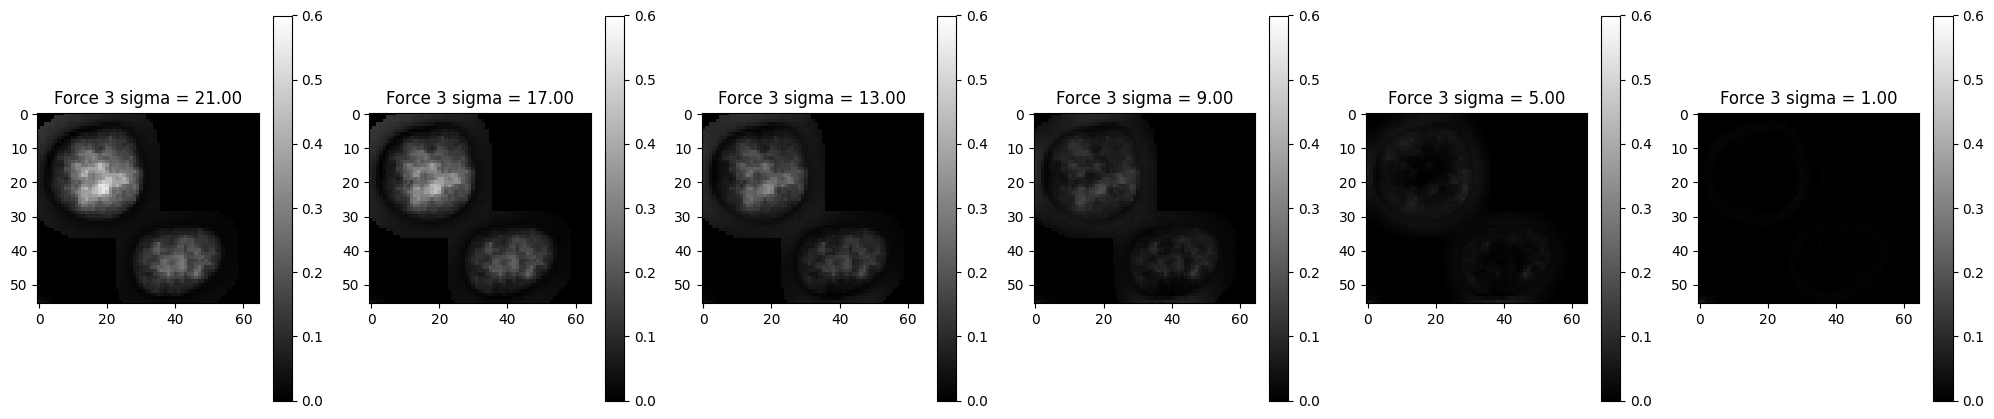

In [7]:
vmin_r3, vmax_r3 = 0, 0.6
fig, ax = plt.subplots(1,N, figsize=(5*(N-1),5))
for i, sigma in enumerate(sigma_list[::-1]):
    force3 = Force3(image, k0=k0, k1=k1, sigma=sigma)
    r3 = force3.compute_force(initial_level_set>0)
    
    ax[i].set_title(f'Force 3 sigma = {sigma:.2f}')
    pos = ax[i].imshow(r3, 'gray', vmin=vmin_r3, vmax=vmax_r3)
    fig.colorbar(pos, ax=ax[i])

**Observation**

In our current case the region outside is practically zero, so ONLY in this example $f_{in} - f_{out}\approx I$ for lower values of $\sigma$, which means we are getting values similar to zero in our force.

<span style="color:red">"Note that for $\sigma$ to $\infty$ the energy E3 converges to the energy E1 since the local mean values
fi in E3 converge to the global mean values $\mu_1$ in E1."</span>. Esto me está matando porque las energias si las miro me queda una integral ahi extra en el articulo y no me cierra bien como es que supuestamente esto sería cierto. Y ahora en la practica (suponiendo que la implementación está okey) no me estaría convergiendo la fuerza de 3 a la de 1 al aumentar el sigma me queda como la inversa tipo opuesta.....

# The Split Bregman Method Applied to Globally Convex Segmentation

In [5]:
# Default parameters for method
lambda_value = 1
nu_value = 0.5
epsilon_value=0.1
gs_error=1e-3

## Using force 1

----------------- Iteration error 0.8700236246608009 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1402/10000 [00:05<00:34, 247.82it/s]


The solution converged after 1402 iterations
----------------- Iteration error 0.6012317998865605 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1446/10000 [00:06<00:36, 236.29it/s]


The solution converged after 1446 iterations
----------------- Iteration error 0.25548236461147417 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1449/10000 [00:06<00:35, 241.09it/s]


The solution converged after 1449 iterations
----------------- Iteration error 0.17934898814053488 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1447/10000 [00:05<00:35, 242.36it/s]


The solution converged after 1447 iterations
----------------- Iteration error 0.13902397334859312 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1446/10000 [00:06<00:36, 234.35it/s]


The solution converged after 1446 iterations
----------------- Iteration error 0.1205376982865722 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1444/10000 [00:06<00:36, 234.18it/s]


The solution converged after 1444 iterations
----------------- Iteration error 0.12171601749139245 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1443/10000 [00:06<00:37, 228.61it/s]


The solution converged after 1443 iterations
----------------- Iteration error 0.11585421578858164 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1443/10000 [00:06<00:36, 233.69it/s]


The solution converged after 1443 iterations
----------------- Iteration error 0.10533201020569914 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1442/10000 [00:05<00:34, 251.33it/s]


The solution converged after 1442 iterations
----------------- Iteration error 0.10720064105625197 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1441/10000 [00:06<00:39, 215.51it/s]


The solution converged after 1441 iterations
Converged with an error 0.09124782974391564


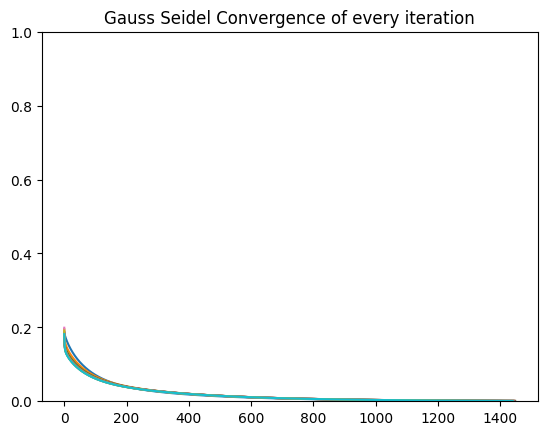

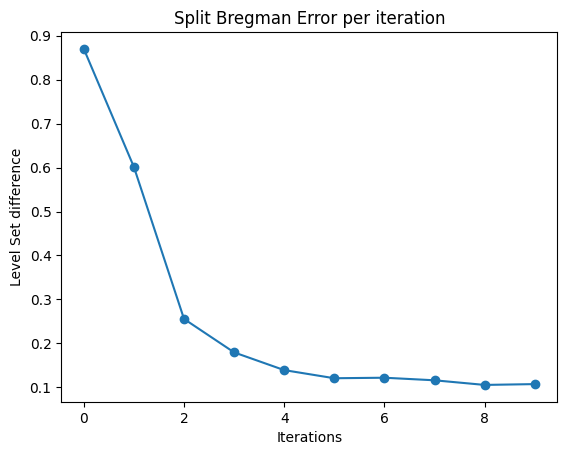

In [6]:
force1 = Force1(image, k1=k1, k0=k0)
segmentator = SplitBregmanGCS(
    force1,
    lambda_value=lambda_value,
    nu_value=nu_value,
    epsilon_value=epsilon_value,
    gs_error=gs_error,
    debug=True)

last_level_set, last_level_set_no_normalized = segmentator.run(initial_level_set)

**Observation**

Looking at the error graphs we can say that the algorithm coverge, so we should be able to have a good segmentation

<a list of 11 text.Text objects>

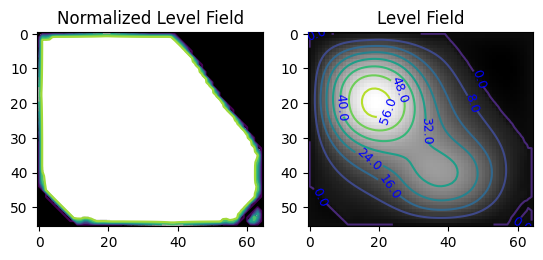

In [11]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Normalized Level Field')
pos = ax[0].imshow(last_level_set, 'gray')
ax[0].contour(last_level_set)
ax[1].set_title('Level Field')
ax[1].imshow(last_level_set_no_normalized, 'gray')
cs = ax[1].contour(last_level_set_no_normalized)
ax[1].clabel(cs, fmt='%2.1f', colors='blue', fontsize=9)

**Observation**

In the article the normalization of the level set is not specify, first we decided to normalized as it is suggested in *T.Goldstein, X.Bresson, and S.Osher. Geometric applications of the split Bregman method*, they clipped the level set between 0 and 1. Clearly this method is not good, because we lose important information, in the graph above we can see that without normalization we can see coherent diferent level sets but all their values are greater than 1. In the code this normalization mode is:  `NormalizationMode.Clip`

**Alternative**

Then, we modify the normalization by clipping all the level set using the min and max value of the first level set(`NormalizationMode.FirstImageParameters`).

----------------- Iteration error 0.8700236246608009 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1402/10000 [00:06<00:36, 233.12it/s]


The solution converged after 1402 iterations
----------------- Iteration error 0.18679710819589943 ------------------------


Gauss Seidel Iteration:  14%|█▍        | 1408/10000 [00:06<00:37, 231.98it/s]


The solution converged after 1408 iterations
Converged with an error 0.0911956154497904


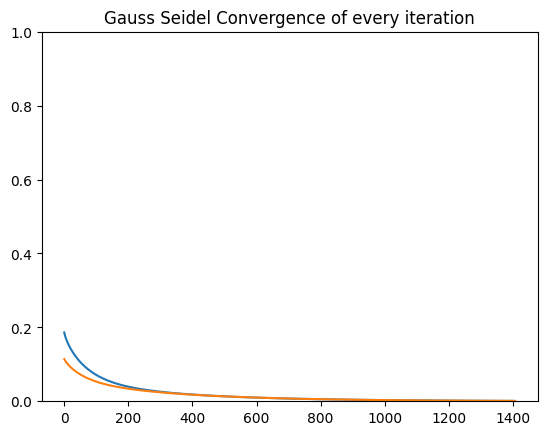

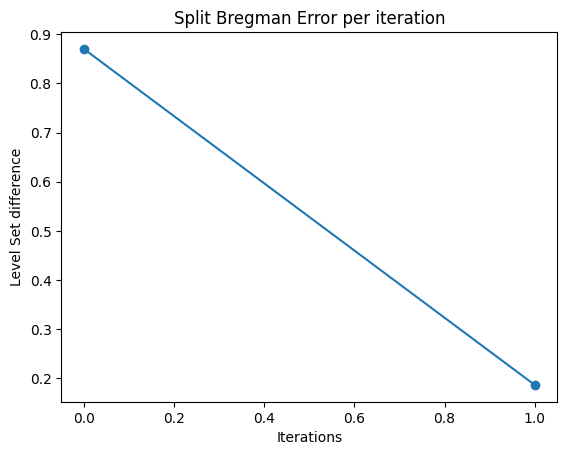

In [7]:
force1 = Force1(image, k1=1, k0=1)
segmentator = SplitBregmanGCS(
    force1,
    lambda_value=lambda_value,
    nu_value=nu_value,
    epsilon_value=epsilon_value,
    gs_error=gs_error,
    mode=NormalizationMode.FirstImageParameters,
    debug=True)

last_level_set, last_level_set_no_normalized = segmentator.run(initial_level_set)

<a list of 7 text.Text objects>

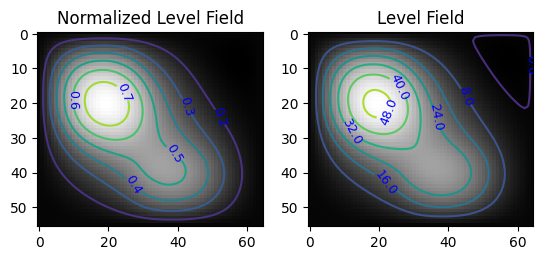

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].set_title('Normalized Level Field')
ax[0].imshow(last_level_set, 'gray')
cs = ax[0].contour(last_level_set)
ax[0].clabel(cs, fmt='%2.1f', colors='blue', fontsize=9)
ax[1].set_title('Level Field')
ax[1].imshow(last_level_set_no_normalized, 'gray')
cs = ax[1].contour(last_level_set_no_normalized)
ax[1].clabel(cs, fmt='%2.1f', colors='blue', fontsize=9)

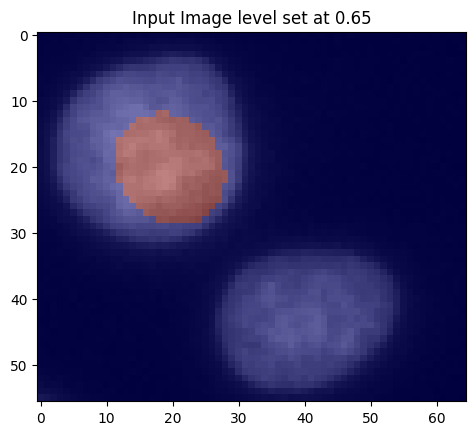

In [10]:
alpha = 0.65
level_set_at_alpha = last_level_set > alpha
fig, ax = plt.subplots(1,1)
ax.set_title(f'Input Image level set at {alpha}')


ax.imshow(image, cmap='gray')
ax.imshow(level_set_at_alpha, 'jet', interpolation='none', alpha=0.5)